# Análise das notícias sob a ótica ESG: estudos

- Autor: Daniel Saraiva Leite - 2023
- Projeto Análise de sentimentos sobre notícias do tema ESG

In [13]:
import warnings
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import datetime  as dt
from noticias_timeline import plota_timeline
from noticias_processamento_texto import *
from noticias_graficos import *
from analise_sentimento_modelo_gpt import *
from classificador_esg import aplica_classificador_esg
from noticias_io import *

warnings.filterwarnings('ignore')


## Descrevendo o conjunto de dados

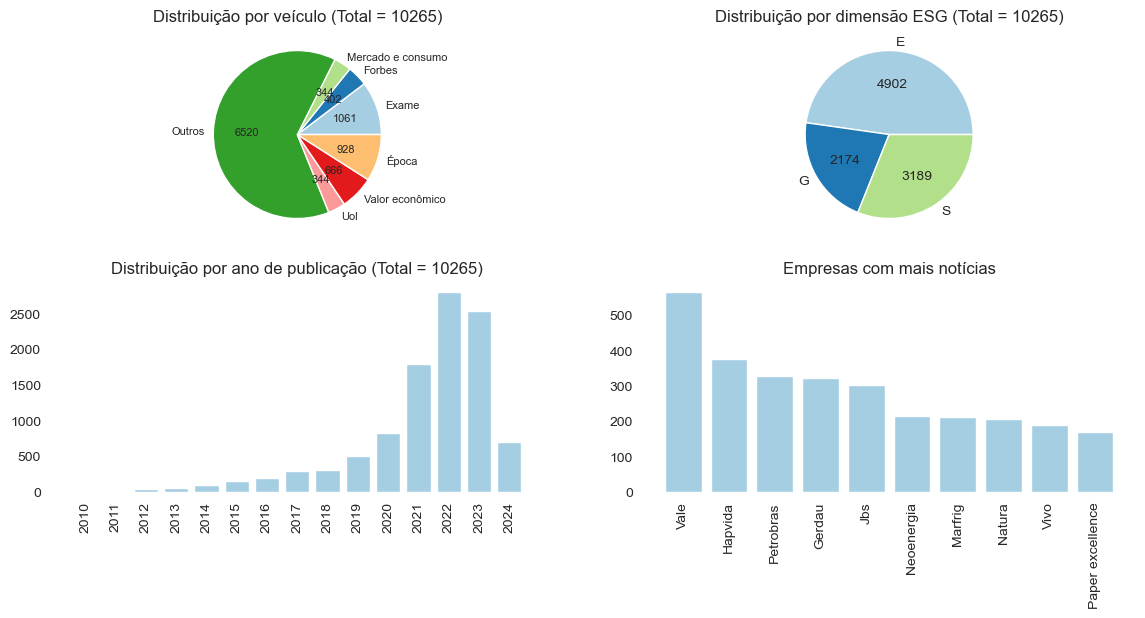

In [14]:
df = le_base_noticias_processada_para_df()

plotar_descricao_base(df, plotar_histograma=False, arquivo=r'static/images/descricao_base.png')

In [ ]:
df['polaridade'].plot.hist().set_ylabel('Frequência')
plt.savefig(r'static/images/histograma_base.png', bbox_inches='tight')
plt.show()

## Definindo a empresa para análise específica

In [ ]:
empresa = 'braskem'
dfEmpresa = df[df['empresa'] == empresa]

## Executando o modelo de polaridade média (EWMA)

In [ ]:
calibragem_alfa = [0.07, 0.075, 0.1, 0.15]

In [ ]:
lista_dfs_polaridade = [gera_curva_polaridade_media(df, empresa, 'ESG', alfa=calibragem_alfa[0]),
                        gera_curva_polaridade_media(df, empresa, 'E', alfa=calibragem_alfa[1]),
                        gera_curva_polaridade_media(df, empresa, 'S', alfa=calibragem_alfa[2]),
                        gera_curva_polaridade_media(df, empresa, 'G', alfa=calibragem_alfa[3])]

In [ ]:
plotar_gauge_polaridade(df, empresa=empresa, dimensao='ESG', df_pol=lista_dfs_polaridade[0])
plotar_gauge_polaridade(df, empresa=empresa, dimensao='E', df_pol=lista_dfs_polaridade[1])
plotar_gauge_polaridade(df, empresa=empresa, dimensao='S', df_pol=lista_dfs_polaridade[2])
plotar_gauge_polaridade(df, empresa=empresa, dimensao='G', df_pol=lista_dfs_polaridade[3])

In [ ]:
plota_polaridade_media_sintetico(df, empresa, arquivo=r'static/images/pol_media_sintetico.png', lista_dfs_polaridade=lista_dfs_polaridade)

## Comparativo com Polaridade com rankings mercado

In [ ]:
df_recente = df[df.data_publicacao.dt.date >= dt.date(2021, 1, 1)]
df_recente = df_recente[df_recente.data_publicacao.dt.date <= dt.date(2022, 12, 31)]
df_recente['ano'] = df_recente.data_publicacao.dt.year
media_ano_count = df_recente.groupby(by=['empresa', 'ano'], as_index=False).count()
media_ano = media_ano_count['titulo'].mean()
media_ano = round(media_ano)
print('Media ano: ' + str(media_ano))

dfB3 = None

dfEmpresasComparar = le_lista_empresas_para_df()
dfEmpresasComparar = pd.merge(left=dfEmpresasComparar, right=pd.read_excel('datasets/EscoreB3.xlsx'), on='RAZÃO SOCIAL', how='left')


dfEmpresasComparar = pd.merge(left=dfEmpresasComparar, right=pd.read_excel('datasets/EscoreMerco.xlsx'), on='Nome', how='left')

df_yahoo = pd.read_excel('datasets/escore_yahoo.xlsx')
df_yahoo = df_yahoo[df_yahoo.Date.dt.date <= dt.date(2023, 1, 1)]
df_yahoo = df_yahoo[df_yahoo.Date.dt.date >= dt.date(2021, 1, 1)]
df_yahoo = pd.merge(left=df_yahoo.groupby(by=['Nome'], as_index=False)['Date'].max(), 
                   right=df_yahoo.loc[:, ['Date', 'Nome', 'Escore_Yahoo_Norm' ]], 
                   on=['Nome', 'Date'], how='left')

dfEmpresasComparar = pd.merge(left=dfEmpresasComparar, right=df_yahoo, on='Nome', how='left')  #Escore_Yahoo_Norm



data_analise = dt.date(2023, 1, 1)  

dfAnalise = df[df['data_publicacao'].dt.date <= data_analise ]

dfEmpresasComparar = dfEmpresasComparar[ (~pd.isnull(dfEmpresasComparar['SCORE ISE B3'])) | (~pd.isnull(dfEmpresasComparar['Escore Merco']))  | (~pd.isnull(dfEmpresasComparar['Escore_Yahoo_Norm']))  ]  # somente considera B3 ou MERCO



dfEmpresasComparar['QtdeNoticias'] =  dfEmpresasComparar.apply(lambda row: len(dfAnalise[dfAnalise.empresa == remove_acentos(row['Nome'].lower())]),  axis=1)

def obtem_ultima_polaridade_base100(dfAnalise, empresa, data_analise, alfa):
    
    dfRes = gera_curva_polaridade_media(dfAnalise, empresa=remove_acentos(empresa.lower()), dimensao='ESG', alfa=alfa)
    if dfRes is not None and len(dfRes) > 0:
        return 100.0 * dfRes['polaridade_fit'].iloc[-1]
    else:
        return None
        
        
qtde_minima = 18
dfEmpresasComparar['Polaridade'] = dfEmpresasComparar.apply(lambda row: obtem_ultima_polaridade_base100(dfAnalise, row['Nome'], data_analise, alfa=0.1) if row['QtdeNoticias'] >= qtde_minima else None   , axis=1)
dfEmpresasComparar.to_excel('datasets/resultado_comp_rankings.xlsx')

rankings = {'Polaridade' : 'Polaridade (Sentimento)', 
            'SCORE ISE B3' : 'ISE B3', 
            'Escore Merco': 'MERCO', 
            'Escore_Yahoo_Norm' : 'Yahoo / Sustainalytics'}

dfEmpresasComparar = dfEmpresasComparar.loc[:, ['Nome'] + list(rankings.keys()) + ['QtdeNoticias']].drop_duplicates()

def correl_ranking(dfEmpresasComparar, a, b, p_valor=0):
    return scipy.stats.spearmanr(dfEmpresasComparar[a], dfEmpresasComparar[b])[p_valor]

df_resultado_correl = None
    
for a in [0.03, 0.05, 0.07,  0.1, 0.2, 0.3]:
    
    dfEmpresasComparar['Polaridade'] = dfEmpresasComparar.apply(lambda row: obtem_ultima_polaridade_base100(dfAnalise, row['Nome'], data_analise, alfa=a) if row['QtdeNoticias'] >= qtde_minima else None   , axis=1)    
    
    pares = [(a, b) for idx, a in enumerate(rankings.keys()) for b in list(rankings.keys())[idx + 1:]]
    for p in pares:
        
        df_correl_par = dfEmpresasComparar[['Nome', p[0], p[1]]][ (~pd.isnull(dfEmpresasComparar[p[0]])) &  (~pd.isnull(dfEmpresasComparar[p[1]])) ].drop_duplicates()
        

        correl = correl_ranking(df_correl_par, p[0], p[1])
        pvalor = correl_ranking(df_correl_par, p[0], p[1], p_valor=1)

        df_correl_par_resultado = pd.DataFrame( {'Alfa' : [a], 'Ranking A': [rankings[p[0]]],
                                                 'Ranking B': [rankings[p[1]]], 'Correlação' : correl,
                                                 'P-valor' : pvalor
                                                })
        if df_resultado_correl is None:
            df_resultado_correl = df_correl_par_resultado
        else:
            df_resultado_correl = pd.concat([df_resultado_correl, df_correl_par_resultado])

df_resultado_correl.to_excel('datasets/resultado_correlacao.xlsx', index=False)


plotar_correlacao_rankings(df_resultado_correl, qtd_media_anual=media_ano)

## Médias anuais

In [ ]:
df_recente = df[df.data_publicacao.dt.date >= dt.date(2021, 1, 1)]
df_recente = df_recente[df_recente.data_publicacao.dt.date <= dt.date(2022, 12, 31)]
df_recente = df_recente[df_recente['classificacao'] == 'G']
media_ano = df_recente.groupby(by=['empresa', df_recente.data_publicacao.dt.year], as_index=False).count()['titulo'].mean()
media_ano = round(media_ano)
print('Media ano geral G: ' + str(media_ano))
# 0.2

In [ ]:
df_recente = df[df.data_publicacao.dt.date >= dt.date(2021, 1, 1)]
df_recente = df_recente[df_recente.data_publicacao.dt.date <= dt.date(2022, 12, 31)]
df_recente = df_recente[df_recente['classificacao'] == 'E']
media_ano = df_recente.groupby(by=['empresa', df_recente.data_publicacao.dt.year], as_index=False).count()['titulo'].mean()
media_ano = round(media_ano)
print('Media ano geral E: ' + str(media_ano))
# 0.075

In [ ]:
df_recente = df[df.data_publicacao.dt.date >= dt.date(2021, 1, 1)]
df_recente = df_recente[df_recente.data_publicacao.dt.date <= dt.date(2022, 12, 31)]
df_recente = df_recente[df_recente['classificacao'] == 'S']
media_ano = df_recente.groupby(by=['empresa', df_recente.data_publicacao.dt.year], as_index=False).count()['titulo'].mean()
media_ano = round(media_ano)
print('Media ano geral S: ' + str(media_ano))
# 0.1

In [ ]:
df_recente = df[df.data_publicacao.dt.date >= dt.date(2021, 1, 1)]
df_recente = df_recente[df_recente.data_publicacao.dt.date <= dt.date(2022, 12, 31)]
media_ano = df_recente.groupby(by=['empresa', df_recente.data_publicacao.dt.year], as_index=False).count()['titulo'].mean()
media_ano = round(media_ano)
print('Media ano geral total: ' + str(media_ano))
# 